# Аналитический отчет для HR-отдела

Цель - составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.

<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Необходимо сделать обзор штата сотрудников компании. Составить набор предметов исследования, а затем проверьте их на данных. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruting_costs`, `salary_grid`.

In [2]:
import psycopg2  # Uses for PostgreSQL
import pandas as pd
import sqlite3

pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "human_resources",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

# Делается запрос к базе, чтобы получить весь список публичных таблиц
#sql_str = "SELECT table_name, table_schema FROM information_schema.tables WHERE table_schema='public';"
#cursor.execute(sql_str)
#tables_list = [a[0] for a in cursor.fetchall()]  # Перебор таблиц в базе

# Задаем список таблиц для анализа, прописанных в условии задания
tables_list = ['hr_dataset', 'production_staff', 'recruiting_costs', 'salary_grid']
tables = {}  # Делаем словарь, который будет использоваться для хранения названия таблиц и его колонок
for table in tables_list:
    try:
        cursor.execute(f"SELECT * FROM {table} LIMIT 0;")
        tables[table] = [column[0] for column in cursor.description]
    except:
        print(f'{table} не подгружается')
        pass

for table in tables_list:
    if table in tables:
        print(f'Таблица {table}')
        print(f'{tables[table]}')
        print()
    else:
        print(f'{table} ничего не выгрузилось')

conn.close()

Таблица hr_dataset
['id', 'Employee Name', 'Employee Number', 'marriedid', 'maritalstatusid', 'genderid', 'empstatus_id', 'deptid', 'perf_scoreid', 'age', 'Pay Rate', 'state', 'zip', 'dob', 'sex', 'maritaldesc', 'citizendesc', 'Hispanic/Latino', 'racedesc', 'Date of Hire', 'Days Employed', 'Date of Termination', 'Reason For Term', 'Employment Status', 'department', 'position', 'Manager Name', 'Employee Source', 'Performance Score']

Таблица production_staff
['id', 'Employee Name', 'Race Desc', 'Date of Hire', 'TermDate', 'Reason for Term', 'Employment Status', 'Department', 'Position', 'Pay', 'Manager Name', 'Performance Score', 'Abutments/Hour Wk 1', 'Abutments/Hour Wk 2', 'Daily Error Rate', '90-day Complaints']

Таблица recruiting_costs
['id', 'Employment Source', 'January ', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'Total']

Таблица salary_grid
['id', 'Position', 'Salary Min', 'Salary Mid', 'Salary Max', 'Hourly 

In [3]:
# Скрипт ниже выгружает всю информацию из таблиц для анализа и сохраняет их в csv файлы, чтобы можно было визуально с ними ознакомиться
import pandas as pd

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

for table in tables_list:
    sql_str = f'SELECT * FROM {table}'    
    cursor.execute(sql_str)
    
    dataset = pd.DataFrame([a for a in cursor.fetchall()], columns=[a[0] for a in cursor.description])
    dataset.to_csv(f'Data/{table}.csv', encoding='utf-8')


conn.close()
print('Completed')

Completed


## Описание таблиц
<h4>Таблица hr_dataset</h4>


Таблица содержит в себе информацию о всех работниках компании и базовую информацию о каждом.

Интересные колонки:

- `sex`, `maritaldesc` - пол и брачный статус сотрудника
- `citizendesc`, `Hispanic/Latino`, `racedesc` - данные по гражданству, цвету кожи сотрудника
- `Pay Rate` - зарплата сотрудника
- `department` - департамент
- `Manager Name` - имя менеджера сотрудника
- `Empoyee Source` - источник от куда сотрудник пришел
- `Perfomance Score` - оценка эффективности сотрудника
- `Employment Status`, `Reason For Term` - статус занятости (Уволен, Еще работает, Сам уволился) и причины по которым произошло изменение 


<h4>Таблица production_staff</h4>


Содержит в себе информацию об оценках отдела Production. По большей части столбцы повторяют информацию `hr_dataset`, но только по отделу Production, дополнительная информация:

- `Daily Error Rate` - дневные ошибки
- `90-day Complaints` - жалобы на сотрудника за последние 90 дней
- `Abutments/Hour Wk 1` - не понятно что отражает


<h4>Таблица recruiting_costs</h4>


Содержит в себе информацию по расходам по подбору персонала по месяцам в разрезе источника от куда сотрудник пришел


<h4>Таблица salary_grid</h4>

Содержит в себе информацию о минимальных, средних и максимальных зарплатных ставках по каждой позиции

## Обзор штата сотрудников 
<i>(все расчеты приведены в блоках ниже)</i>

- Половой состав: Больше всего в компании женщин - 101 (или 55% от общего числа сотрудников) при этом их средняя зарплата составила 32.15 долл/час, мужчин в компании - 82 человека (45%), их зарплата была выше женской на 12% и составила 35.90 долл/час

- Брачный состав: Наибольшее количество сотрудников не замужем - 92 человек (50% всех сотрудников), замужем 65 человек (~36%), также присутствуют разведенные сотрудники (14 человек), живущие раздельно (8 человек) и овдовленные (4 человек)

- Рассовый состав: 63% всех сотрудников - белые (115 человека), 36 человек - черные (20% всех сотрудников) и 18 азиата (10% всех сотрудников).

- Состав по отделам: Самый большой отдел Production - 106 человек (это более 58% людей), IT/IS отдел - 35 человек (>19% людей), отдел продаж насчитывает 26 человек (14% людей), admin office имеет 8 человек (4%) и software engineering 7 человек

In [110]:
import psycopg2  # Uses for PostgreSQL
import pandas as pd
pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "human_resources",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}

# Ниже приведен код для обзора штата сотрудников
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

query_gender_view = """SELECT sex, COUNT('Employee Number'), 
                              ROUND(COUNT('Employee Number') * 100.0 / (SELECT COUNT('Employee Number') FROM hr_dataset WHERE empstatus_id = 1), 1) as Share,
                              AVG(hr_dataset."Pay Rate") as Average_Payrate,
                              AVG(hr_dataset."Days Employed") as Average_Days_Employed
                    FROM hr_dataset
                    WHERE empstatus_id = 1
                    GROUP BY sex;"""
cursor.execute(query_gender_view)
genders = pd.DataFrame([a for a in cursor.fetchall()], columns=[a[0] for a in cursor.description]).sort_values('count')

query_marital_view = """SELECT maritaldesc, COUNT('Employee Number'), 
                               ROUND(COUNT('Employee Number') * 100.0 / (SELECT COUNT('Employee Number') FROM hr_dataset WHERE empstatus_id = 1), 1) as Share, 
                               AVG(hr_dataset."Pay Rate") as Average_Payrate
                     FROM hr_dataset
                     WHERE empstatus_id = 1 
                     GROUP BY maritaldesc;"""
cursor.execute(query_marital_view)
marital = pd.DataFrame([a for a in cursor.fetchall()], columns=[a[0] for a in cursor.description]).sort_values('count')

query_races_view = """SELECT racedesc, COUNT('Employee Number'), 
                             ROUND(COUNT('Employee Number') * 100.0 / (SELECT COUNT('Employee Number') FROM hr_dataset WHERE empstatus_id = 1), 1) as Share, 
                             AVG(hr_dataset."Pay Rate") as Average_Payrate
                   FROM hr_dataset 
                   WHERE empstatus_id = 1
                   GROUP BY racedesc;"""
cursor.execute(query_races_view)
races = pd.DataFrame([a for a in cursor.fetchall()], columns=[a[0] for a in cursor.description]).sort_values('count')

query_departments_view = """SELECT department, COUNT('Employee Number'), 
                                   ROUND(COUNT('Employee Number') * 100.0 / (SELECT COUNT('Employee Number') FROM hr_dataset WHERE empstatus_id = 1), 1) as Share, 
                                   AVG(hr_dataset."Pay Rate") as Average_Payrate
                         FROM hr_dataset 
                         WHERE empstatus_id = 1
                         GROUP BY department;"""
cursor.execute(query_departments_view)
departments = pd.DataFrame([a for a in cursor.fetchall()], columns=[a[0] for a in cursor.description]).sort_values('count')

query_citezenship_view = """SELECT citizendesc, COUNT('Employee Number'), 
                                   ROUND(COUNT('Employee Number') * 100.0 / (SELECT COUNT('Employee Number') FROM hr_dataset WHERE empstatus_id = 1), 1) as Share,
                                   AVG(hr_dataset."Pay Rate") as Average_Payrate
                         FROM hr_dataset 
                         WHERE empstatus_id = 1
                         GROUP BY citizendesc;"""
cursor.execute(query_citezenship_view)
citezenship = pd.DataFrame([a for a in cursor.fetchall()], columns=[a[0] for a in cursor.description]).sort_values('count')

conn.close()
genders

,sex,count,share,average_payrate,average_days_employed
1,Male,82,44.8,35.908537,1538.7926829268292683
0,Female,101,55.2,32.153168,1672.9900990099009901


In [2]:
# Задаются параметры подключения в серверу SQL
pg_connection = {
        "host": "dsstudents.skillbox.ru",
        "port": 5432,
        "dbname": "human_resources",
        "user": "readonly",
        "password": "6hajV34RTQfmxhS"
    }

In [3]:
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import psycopg2  # Uses for PostgreSQL
import qgrid

----------

## Факторы, влияющие на размер оплаты труда

Ниже приведен анализ заработной платы сотрудников в зависимости от различных факторов. Суть анализа сводится к тому, что мы будем сравнивать среднюю заработную плату сотрудников на одинаковой должности в разрезе факторов, которые могут влиять на ее абсолютный размер.

- На зарплату влияют гендерные признаки 

    Из графиков видно, что существенной зависимости зарплаты от пола сотрудика нет. Существенное отклонение зарплат присутствует только на одной позиции в департаменте IT/IS по должности Network Engineer - мужчины на данной позиции получают в среднем на 20% больше, чем женщины, при этом следует отметить, что мужчин и женщин на данной позиции работает поровну (4 мужчины и 4 женщины).
    Также стоит отметить, что на некоторых позициях отдела департамента IT/IS работают только одни мужчины (BI Developer), либо одни женщины (IT Support).

In [7]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = np.round(rect.get_width(),1)
        subplot.annotate('{}'.format(height),
                    xy=(height, rect.get_y()),
                    xytext=(15, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

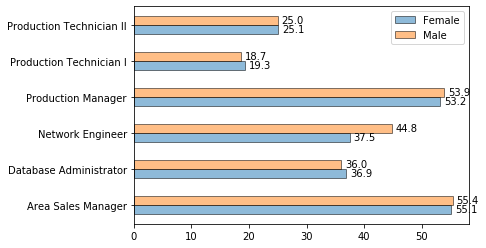

In [24]:
# Ниже приведен код для обзора штата сотрудников

def pay_vs_gender(connection, print=True):
    """Сравнение зарплаты в зависимости от пола сотрудника"""    
    
    conn = psycopg2.connect(**connection)
    cursor = conn.cursor()

    query_pay_vs_gender = """SELECT department, position, sex, 
                                    AVG(hr_dataset."Pay Rate") as "Pay Rate",
                                    COUNT(hr_dataset."Pay Rate") as "count"
                             FROM hr_dataset 
                             WHERE empstatus_id = 1
                             GROUP BY department, position, sex
                             ORDER BY department ASC, position ASC, "Pay Rate" DESC;"""

    cursor.execute(query_pay_vs_gender)
    pay_vs_gender = pd.DataFrame([a for a in cursor.fetchall()], columns=[a[0] for a in cursor.description])
    pay_vs_gender = pay_vs_gender.set_index(['department', 'position', 'sex']).sort_values(['department', 'position', 'sex'])
    pay_vs_gender = pay_vs_gender[pay_vs_gender['count'] > 2] # На данном шаге оставляем все отделы, где больше 2х сотрудников
    conn.close()
    
    return pay_vs_gender
    

pay_vs_gender_df = pay_vs_gender(pg_connection)

# Поскольку много позиций, на которых работает по одной расовой группе, то мы отбросим для построения графика такие группы
more_than_one_gender = pay_vs_gender_df.groupby(['department', 'position'])['Pay Rate'].transform('count')
more_than_one_gender = pay_vs_gender_df.loc[more_than_one_gender>1]
more_than_one_gender = more_than_one_gender.reset_index().set_index(['sex', 'position'])
more_than_one_gender = more_than_one_gender.sort_values('position')


gender_list = more_than_one_gender.index.get_level_values(level='sex').drop_duplicates()
position_list = more_than_one_gender.index.get_level_values(level='position').drop_duplicates()

# Задаем положения графиков на оси ординат
y_values= np.empty((len(position_list), len(gender_list)))

# Задаем толщину колонок графика
height = 1 / 8

for i in range(len(position_list)):
    # У нас 3 позиции
    # По каждой позици 4 столбика с расой
    y_values[i] = np.linspace(i - height, 
                              i + height, 
                              len(gender_list))


fig, subplot = plt.subplots()
# Далее строим график на каждую группу
for gender_number, gender in enumerate(gender_list):
    # Поскольку на некоторых позициях нет всех 4х рас, то будем использовать шаблон
    # Так на графике у рас, которых нет в исходном датафрейме будут нули
    draft_df = pd.DataFrame(0, 
                            index=more_than_one_gender.index.get_level_values(level='position').drop_duplicates(),
                            columns=['Pay Rate'])
    draft_df = draft_df + more_than_one_gender.loc[gender][['Pay Rate']]  # Заполняем шаблон фактическими значениями
    draft_df = draft_df.fillna(0)

    # Сохраняем для нанесения подписей в том же порядке, в котором они будут на графике
    positions_list = draft_df.index.to_list()
    plot_n = subplot.barh(y_values[:, gender_number], 
                 draft_df['Pay Rate'], 
                 height=height*2,
                 label = gender, 
                 alpha=0.5, edgecolor='black') 
    autolabel(plot_n)  # Достраиваем подписи

# Делаем подписи оси
subplot.set_yticks(range(len(position_list)))
subplot.set_yticklabels(positions_list)
subplot.legend()
pass

- Размер зарплаты в зависимости от расы сотрудника

    Зарплата практически не варьируется в зависимости от расы сотрудников, это видно на графике ниже




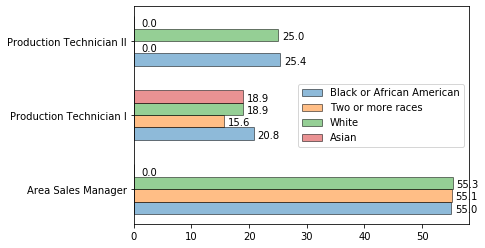

In [152]:
import psycopg2  # Uses for PostgreSQL
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt


# Ниже приведен код для обзора штата сотрудников

def pay_vs_race(connection, printing=True):
    """Сравнение зарплаты в зависимости от пола сотрудника"""    
    
    conn = psycopg2.connect(**connection)
    cursor = conn.cursor()

    query_pay_vs_race = """SELECT department, position, racedesc as "race", 
                                    AVG(hr_dataset."Pay Rate") as "Pay Rate",
                                    COUNT(hr_dataset."Pay Rate") as "count"
                             FROM hr_dataset 
                             WHERE empstatus_id = 1
                             GROUP BY department, position, racedesc
                             ORDER BY department ASC, position ASC, "Pay Rate" DESC;"""

    cursor.execute(query_pay_vs_race)
    pay_vs_race = pd.DataFrame([a for a in cursor.fetchall()], 
                               columns=[a[0] for a in cursor.description])
    pay_vs_race = pay_vs_race.set_index(['department', 'position', 'race']).sort_values(['department', 'position', 'race'])
    pay_vs_race = pay_vs_race[pay_vs_race['count'] > 2] # На данном шаге оставляем все отделы, где больше 2х сотрудников
    conn.close()
    return pay_vs_race

# Выгружаем данные в датафрейм
pay_vs_race_df = pay_vs_race(pg_connection, printing=False)
# Подписи на графике - функция из документации
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = np.round(rect.get_width(),1)
        subplot.annotate('{}'.format(height),
                    xy=(height, rect.get_y()),
                    xytext=(15, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Поскольку много позиций, на которых работает по одной расовой группе, то мы отбросим для построения графика такие группы
more_than_one_race = pay_vs_race_df.groupby(['department', 'position'])['Pay Rate'].transform('count')
more_than_one_race = pay_vs_race_df.loc[more_than_one_race>1]
more_than_one_race = more_than_one_race.reset_index().set_index(['race', 'position'])
more_than_one_race = more_than_one_race.sort_values('position')

# Создаем списки из всех рас и всех позиций, которые будут наносится на график
races_list = more_than_one_race.index.get_level_values(level='race').drop_duplicates()
position_list = more_than_one_race.index.get_level_values(level='position').drop_duplicates()

# Задаем положения графиков на оси ординат
y_values= np.empty((len(position_list), len(races_list)))

# Задаем толщину колонок графика
height = 1 / len(races_list)

for i in range(len(position_list)):
    # У нас 3 позиции
    # По каждой позици 4 столбика с расой
    y_values[i] = np.linspace(i - height, 
                              i + height, 
                              len(races_list))


fig, subplot = plt.subplots()
# Далее строим график на каждую группу
for race_number, race in enumerate(races_list):
    # Поскольку на некоторых позициях нет всех 4х рас, то будем использовать шаблон
    # Так на графике у рас, которых нет в исходном датафрейме будут нули
    draft_df = pd.DataFrame(0, 
                            index=more_than_one_race.index.get_level_values(level='position').drop_duplicates(),
                            columns=['Pay Rate'])
    draft_df = draft_df + more_than_one_race.loc[race][['Pay Rate']]  # Заполняем шаблон фактическими значениями
    draft_df = draft_df.fillna(0)
    
    # Сохраняем для нанесения подписей в том же порядке, в котором они будут на графике
    positions_list = draft_df.index.to_list()
    plot_n = subplot.barh(y_values[:, race_number], 
                 draft_df['Pay Rate'], 
                 height=height/1.5,
                 label = race, 
                 alpha=0.5, edgecolor='black') 
    autolabel(plot_n)  # Достраиваем подписи

# Делаем подписи оси
subplot.set_yticks(range(len(position_list)))
subplot.set_yticklabels(positions_list)
subplot.legend(loc='center right')
pass

- Оценка эффективности сотрудника влияет на его среднюю зарплату

    Корреляция между оценкой и зарплатой есть, но слабовыраженная. Например, на позиции Database Administrator сильная зависимость средней зарплаты от оценки сотрудника, - так сотрудник, который прошел испытательный срок в 90-дней получает на 22% меньше, чем тот, кто получил оценку Fully Meets. Аналогичная ситуация наблюдается на позиции Area Sales Manager, но разница 2%. Есть позиции в которых мы видим обратную зависимость - Software Engineer с оценкой Exceptional получает на 10% меньше, чем сотрудник только прошедший испытательный срок




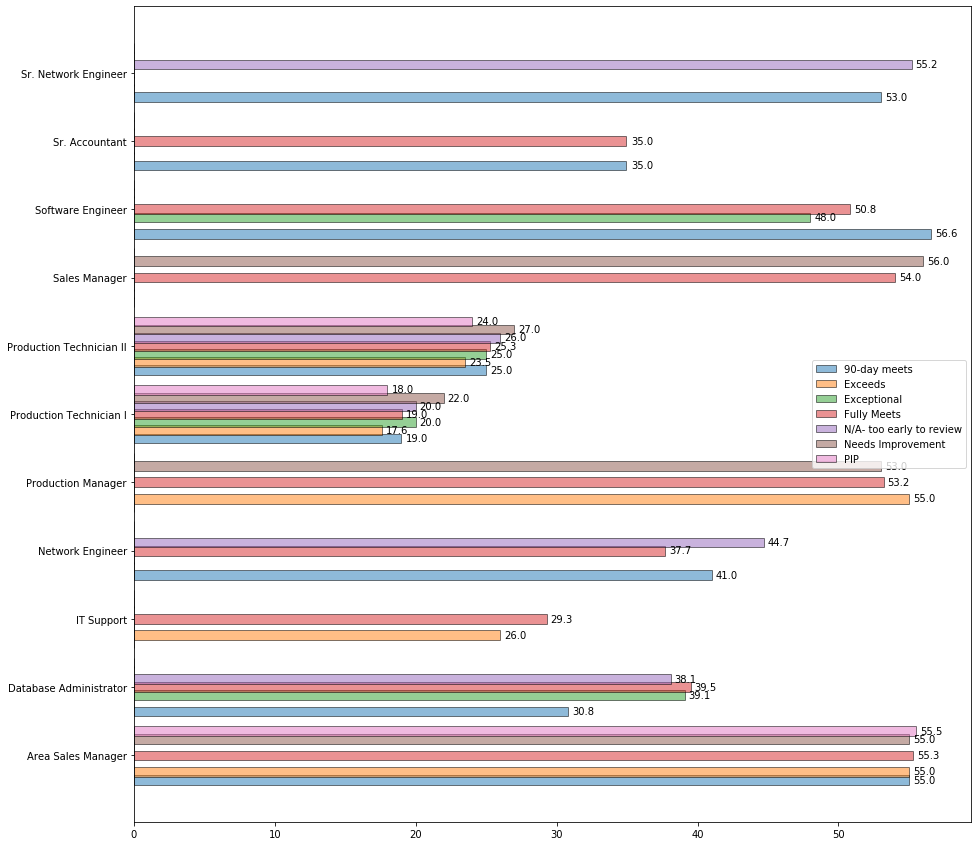

In [172]:
import psycopg2  # Uses for PostgreSQL
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt


# Ниже приведен код для обзора штата сотрудников

def pay_vs_score(connection):
    """Сравнение зарплаты в зависимости от оценки эффективности сотрудника"""    
    
    conn = psycopg2.connect(**connection)
    cursor = conn.cursor()

    query_pay_vs_score = """SELECT department, position, "Performance Score" as score,
                             AVG(hr_dataset."Pay Rate") as "Pay Rate",
                             COUNT(hr_dataset."Pay Rate") as "count"
                             FROM hr_dataset 
                             WHERE empstatus_id = 1
                             GROUP BY department, position, score
                             ORDER BY department ASC, position ASC, "Pay Rate" DESC;"""

    cursor.execute(query_pay_vs_score)
    pay_vs_score = pd.DataFrame([a for a in cursor.fetchall()], 
                               columns=[a[0] for a in cursor.description])
    pay_vs_score = pay_vs_score.set_index(['department', 'position', 'score']).sort_values(['department', 'position', 'score'])
    #pay_vs_score = pay_vs_score[pay_vs_score['count'] > 2] # На данном шаге оставляем все отделы, где больше 2х сотрудников
    conn.close()
    return pay_vs_score

pay_vs_score_df = pay_vs_score(pg_connection)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = np.round(rect.get_width(),1)
        if height!=0:
            subplot.annotate('{}'.format(height),
                        xy=(height, rect.get_y()),
                        xytext=(15, 0),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

# Поскольку много позиций, на которых есть только одна оценка, то отбросим такие и будем строить график только по тем, где можно сравнить
more_than_one_score = pay_vs_score_df.groupby(['department', 'position'])['Pay Rate'].transform('count')
more_than_one_score = pay_vs_score_df.loc[more_than_one_score>1]
more_than_one_score = more_than_one_score.reset_index().set_index(['score', 'position'])
more_than_one_score = more_than_one_score.sort_values('score')

# Создаем списки из всех позиций и всех оценок, которые будут наносится на график
scores_list = more_than_one_score.index.get_level_values(level='score').drop_duplicates()
position_list = more_than_one_score.index.get_level_values(level='position').drop_duplicates()

# Задаем положения графиков на оси ординат
y_values= np.empty((len(position_list), len(scores_list)))

# Задаем толщину колонок графика
height = 1 / len(scores_list)

for i in range(len(position_list)):
    # У нас несколько позиций
    # По каждой позици несколько столбиков с оценкой
    y_values[i] = np.linspace(i - height*2.5, 
                              i + height*2.5, 
                              len(scores_list))


fig, subplot = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(15)
# Далее строим график на каждую группу
for score_number, score in enumerate(scores_list):
    # Поскольку на некоторых позициях нет всех 4х рас, то будем использовать шаблон
    # Так на графике у рас, которых нет в исходном датафрейме будут нули
    draft_df = pd.DataFrame(0, 
                            index=more_than_one_score.index.get_level_values(level='position').drop_duplicates(),
                            columns=['Pay Rate'])
    draft_df = draft_df + more_than_one_score.loc[score][['Pay Rate']]  # Заполняем шаблон фактическими значениями
    draft_df = draft_df.fillna(0)
    
    # Сохраняем для нанесения подписей в том же порядке, в котором они будут на графике
    positions_list = draft_df.index.to_list()
    plot_n = subplot.barh(y_values[:, score_number], 
                 draft_df['Pay Rate'], 
                 height=height,
                 label = score, 
                 alpha=0.5, edgecolor='black') 
    autolabel(plot_n)  # Достраиваем подписи

# Делаем подписи оси
subplot.set_yticks(range(len(position_list)))
subplot.set_yticklabels(positions_list)
subplot.legend()

pass

-------

## Факторы, повлиявшие на увольнения сотрудников



В базе данных компании присутствует 88 записей о сотрудниках, которые добровольно покинули компанию, 14 были уволены.

In [14]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

query_termination_status = """SELECT "Employment Status" as status, count(id)
                         FROM hr_dataset 
                         GROUP BY status
                         ORDER BY count DESC;"""

cursor.execute(query_termination_status)
termination_status = pd.DataFrame([a for a in cursor.fetchall()], columns=[a[0] for a in cursor.description])
conn.close()
termination_status

,status,count
0,Active,183
1,Voluntarily Terminated,88
2,Terminated for Cause,14
3,Leave of Absence,14
4,Future Start,11


- Самой распространенной причиной увольнения является посещаемость - по ней уволили 6 человек, далее результаты работы - 3 человека.

    Стоит отметить, что уволенные за посещаемость в среднем провели в компании более 3х лет

In [13]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()


query_terminated_for_cause = """SELECT "Reason For Term" as reason
                         , COUNT(id) as number
                         , AVG(age) as average_age
                         , AVG("Days Employed") as average_days_employed
                         FROM hr_dataset 
                         WHERE "Employment Status" = 'Terminated for Cause'
                         GROUP BY "Reason For Term"
                         ORDER BY number DESC;"""


cursor.execute(query_terminated_for_cause)
terminated_for_cause = pd.DataFrame([a for a in cursor.fetchall()], columns=[a[0] for a in cursor.description])

query_terminated_for_attendance = """SELECT *
                         FROM hr_dataset 
                         WHERE "Employment Status" = 'Terminated for Cause' and "Reason For Term" = 'attendance';"""
cursor.execute(query_terminated_for_attendance)
terminated_for_attendance = pd.DataFrame([a for a in cursor.fetchall()], columns=[a[0] for a in cursor.description])

conn.close()
terminated_for_cause

,reason,number,average_age,average_days_employed
0,attendance,6,37.5000000000000000,1002.1666666666666667
1,performance,3,35.6666666666666667,544.6666666666666667
2,"no-call, no-show",3,35.3333333333333333,13.6666666666666667
3,gross misconduct,1,32.0000000000000000,1596.0000000000000000
4,hours,1,53.0000000000000000,732.0000000000000000


- Самая распространенная причина ухода сотрудников является новая позиций - больше 20 человек уволились по этой причине.

    Стоит отметить, что уволенные за посещаемость в среднем провели в компании более 3х лет

In [18]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()


query_voluntarily_terminated = f"""SELECT "Reason For Term" as reason
                         , COUNT(id) as number
                         , AVG(age) as average_age
                         , AVG("Days Employed") as average_days_employed
                         , percentile_disc(0.5) within group (order by "Days Employed") as median_days_employed 
                         FROM hr_dataset 
                         WHERE "Employment Status" = '{termination_status.status.loc[1]}'
                         GROUP BY "Reason For Term"
                         ORDER BY number DESC;"""


cursor.execute(query_voluntarily_terminated)
voluntarily_terminated = pd.DataFrame([a for a in cursor.fetchall()], columns=[a[0] for a in cursor.description])


conn.close()
voluntarily_terminated

,reason,number,average_age,average_days_employed,median_days_employed
0,Another position,20,42.1000000000000000,760.0500000000000000,439
1,unhappy,14,41.0000000000000000,743.2857142857142857,581
2,more money,11,41.3636363636363636,762.3636363636363636,514
3,career change,9,38.8888888888888889,765.8888888888888889,718
4,hours,8,39.7500000000000000,477.0000000000000000,299
5,return to school,5,37.0000000000000000,351.8000000000000000,62
6,relocation out of area,5,41.6000000000000000,1001.6000000000000000,1265
7,military,4,43.5000000000000000,1014.2500000000000000,922
8,retiring,4,51.7500000000000000,1148.0000000000000000,1140
9,maternity leave - did not return,3,29.6666666666666667,1386.6666666666666667,1271


In [28]:
conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

query_voluntarily_terminated = f"""SELECT *
                         FROM hr_dataset 
                         left join salary_grid on salary_grid."Position" = hr_dataset.position
                         WHERE "Employment Status" = '{termination_status.status.loc[1]}'
                         and "Reason For Term" = 'more money';"""
cursor.execute(query_voluntarily_terminated)
voluntarily_terminated = pd.DataFrame([a for a in cursor.fetchall()], columns=[a[0] for a in cursor.description])
conn.close()
voluntarily_terminated.drop(['Employee Number', 'marriedid', 'maritalstatusid', 'empstatus_id', 'genderid', 'deptid', 'perf_scoreid', 'Salary Min', 'Salary Mid', 'Salary Max'], axis=1)

,id,Employee Name,age,Pay Rate,state,zip,dob,sex,maritaldesc,citizendesc,...,department,position,Manager Name,Employee Source,Performance Score,id,Position,Hourly Min,Hourly Mid,Hourly Max
0,170,"Rarrick, Quinn",33,21.0,MA,2478,1984-12-31,Male,Divorced,US Citizen,...,Production,Production Technician I,Michael Albert,Pay Per Click - Google,Fully Meets,10,Production Technician I,14.42,19.23,24.04
1,165,"Pham, Hong",30,18.0,MA,2451,1988-03-06,Male,Married,US Citizen,...,Production,Production Technician I,Brannon Miller,Search Engine - Google Bing Yahoo,Fully Meets,10,Production Technician I,14.42,19.23,24.04
2,154,"Ndzi, Horia",35,22.0,MA,2421,1983-03-28,Male,Married,US Citizen,...,Production,Production Technician I,Amy Dunn,Employee Referral,Fully Meets,10,Production Technician I,14.42,19.23,24.04
3,136,"Kirill, Alexandra",47,24.0,MA,2127,1970-10-08,Female,Married,US Citizen,...,Production,Production Technician I,Amy Dunn,Search Engine - Google Bing Yahoo,Fully Meets,10,Production Technician I,14.42,19.23,24.04
4,135,"Kinsella, Kathleen",44,22.0,MA,2170,1973-12-08,Female,Married,US Citizen,...,Production,Production Technician I,Webster Butler,Search Engine - Google Bing Yahoo,90-day meets,10,Production Technician I,14.42,19.23,24.04
5,132,"Johnson, George",58,17.0,MA,2445,1959-08-19,Male,Married,US Citizen,...,Production,Production Technician I,Michael Albert,Monster.com,Exceeds,10,Production Technician I,14.42,19.23,24.04
6,122,"Gross, Paula",35,14.0,MA,2176,1983-05-21,Female,Divorced,US Citizen,...,Production,Production Technician I,Kelley Spirea,Monster.com,Fully Meets,10,Production Technician I,14.42,19.23,24.04
7,247,"Peters, Lauren",31,29.0,MA,1886,1986-08-17,Female,Married,US Citizen,...,Production,Production Technician II,Ketsia Liebig,Pay Per Click - Google,Exceeds,11,Production Technician II,18.27,23.08,27.88
8,234,"Lundy, Susan",41,24.0,MA,2122,1976-12-26,Female,Widowed,US Citizen,...,Production,Production Technician II,Michael Albert,On-campus Recruiting,N/A- too early to review,11,Production Technician II,18.27,23.08,27.88
9,232,"Latif, Mohammed",34,28.0,MA,2126,1984-05-09,Male,Married,US Citizen,...,Production,Production Technician II,Kissy Sullivan,Word of Mouth,Fully Meets,11,Production Technician II,18.27,23.08,27.88
